# Trends and Anomlaies in my Variables

### Explore my SSH, SST, Ekman transport (and wind stress data?)
- period of common data 01/01/1993 - 09/11/2021 -› almost 28 years
#### Maps
1. Slope of Trend at each grid cell
    - whole year (annual mean trend)
    - summer (seasonal mean trend)
2. Anomaly
    -  ref period: 1993 to 2012 (20 years), compared to 2013 to 2021 (8 years)
    -  whole year
    -  summer

#### Climatologies (for UIs)
1. Every week
    - trend, R2, p-value (whole period, last decade)
2. Seasonal mean
    - trend, R2, p-value (whole period, last decade)
    - anomalies

In [5]:
## import packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.patches as mpatches
import matplotlib
import cartopy.crs as ccrs
import glob
import os
import my_functions
import datetime
import statsmodels.api as sm
%matplotlib inline

In [6]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('MTSS_weekly.nc')
UI_SST = UI_SST = xr.open_dataset('UI_SST.nc')
# download CoRTAD SST later
LSM = xr.open_dataset('Land_sea_mask.nc')
SSH = xr.open_dataset('SSH_weekly.nc') # SSH IBI
# mid-shelf coordinates
mid_shelf_lat = np.genfromtxt('CoRTAD/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('CoRTAD/lon_midshelf_CoRTAD.dat')[:,1]

In [46]:
## selct common period
MTSS = MTSS.sel(time = slice('01/01/1993', '09/11/2021'))
UI_SST = UI_SST.sel(time = slice('01/01/1993', '09/11/2021'))
SSH = SSH.sel(time = slice('01/01/1993', '09/11/2021'))

In [179]:
## preprocessing steps
# add the land sea mask to the MTSS dataset
MTSS['lsm'] = LSM.lsm

# calculate upwelling index from wind stress dataset -> use my upwelling function (from my_functions.py)
Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss.where(MTSS.lsm), MTSS.mntss.where(MTSS.lsm))
# SSH upwelling index
# first add mid-shelf
SSH = my_functions.add_mid_shelf(SSH, mid_shelf_lat, mid_shelf_lon)
SSH['UI'] = SSH.zos.where(SSH.lon == -10.5) - SSH.zos.where(SSH.mid_shelf).mean(dim = 'lon')
SSH.UI.attrs.update({'Name' : 'SSH upwelling index', 'Info' : 'SSH at 10.5°W - SSH at mid-shelf'})

# calculate meridional mean (1D Portuguese upwelling index), does meridional mean of UI by default
#UI_Ek = my_functions.calc_meridional_mean(UI_Ek, lon = -10.5) # change to lon -10.5 to match SSH slected location (made this decision together wiht Joaquim, just seemed a good enough distance away from land)
#UI_SST = my_functions.calc_meridional_mean(UI_SST, lon = -15) # specifying lon does not really matter as it is equal across al lons
#UI_SSH = my_functions.calc_meridional_mean(SSH, lon = -10.5)

# create subset of summer months, June-September (week 22-39), subsets week 22-39 by default (adds weeks and months)
Ek_summer = my_functions.subset_summer(Ek)
SST_summer = my_functions.subset_summer(UI_SST)
SSH_summer = my_functions.subset_summer(SSH)

# add mid_shelf
#Ek = my_functions.add_mid_shelf(UI_Ek, mid_shelf_lat, mid_shelf_lon)

## Common Definitions

In [38]:
## Anomaly map 
# define the reference and current periods
# here: first and last ten years of data (i.e. 1993-2002 and 2012-2021)
first_10 = SSH.time.dt.isocalendar().year.min().values + 10 # first date assigned is 29/12/2012 becuase of the weekly averaging and assingning date to Tuesday
last_10 = SSH.time.dt.isocalendar().year.max().values - 9 # minus nine years because the last year is already fully included 01/2021 - 12/2021


## Functions

In [159]:
## plot map

def plot_map(DS, title = 'Title', cmap = 'coolwarm', vmin = None, vmax = None, cbar_label = 'Label'):
    plt.figure(figsize=(10, 6))
        
    # Set up the map 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-19, -5.5, 45, 36])
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
      
    cp = DS.plot(add_colorbar = False, cmap = cmap, vmin = vmin, vmax = vmax)
    plt.title(title)
    plt.colorbar(cp, ax = ax, label = cbar_label, fraction = 0.046, pad = 0.01);


In [128]:
## plot anomaly

def plot_anomaly_map(DS, title = 'Title', cmap = 'coolwarm', vmin = None, vmax = None, cbar_label = 'Label'):
    DS_ref = DS.where(SSH.time.dt.isocalendar().year <= first_10, drop = True).mean(dim = 'time')
    DS_cur = DS.where(SSH.time.dt.isocalendar().year >= last_10, drop = True).mean(dim = 'time')
    DS_anomaly = DS_ref - DS_cur

    plot_map(DS_anomaly, title = title, cmap = cmap, vmin = vmin, vmax = vmax, cbar_label = cbar_label)

    #return DS_anomaly, DS_ref, DS_cur

## SSH

### SSH mean

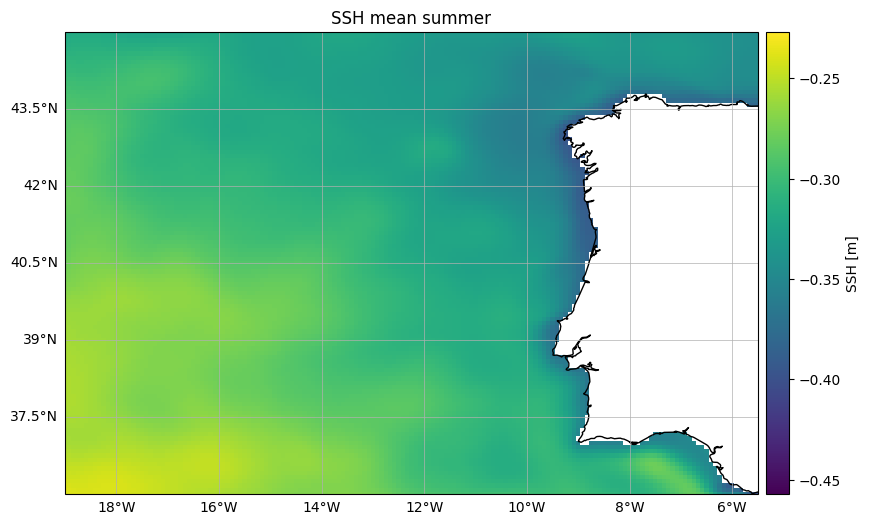

In [160]:
## mean summer SSH
plot_map(SSH_summer.zos.mean(dim = 'time'), title = 'SSH mean summer',
        cmap = 'viridis', cbar_label = 'SSH [m]')

### SSH Trend

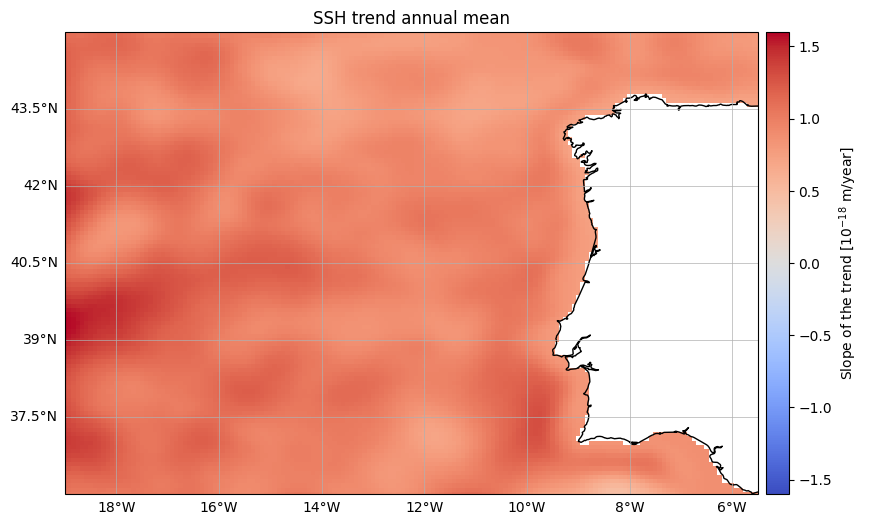

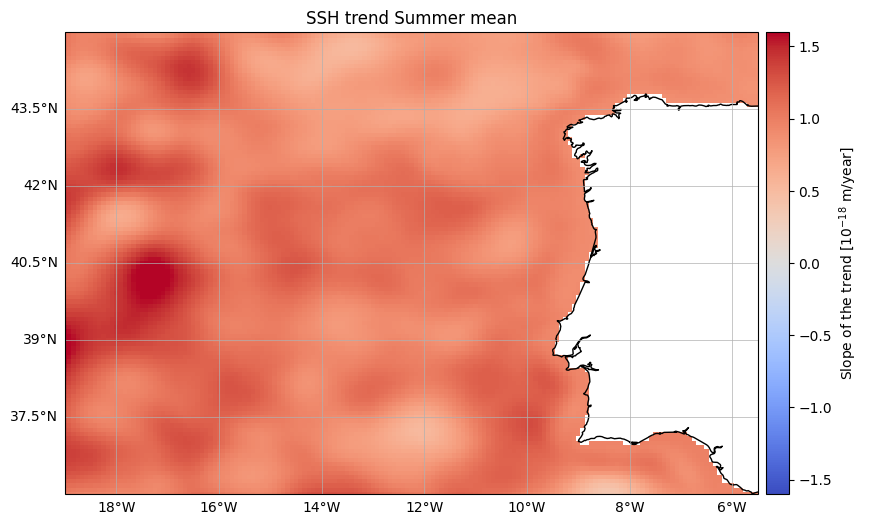

In [229]:
for DS, title in zip([SSH.zos, SSH_summer.zos], ['SSH trend annual mean', 'SSH trend Summer mean']):
    DS_annual = DS.resamcple(time = 'YE').mean() * 10e18 # ato
    result = DS_annual.polyfit(dim = "time", deg = 1)
    
    plot_map(result.polyfit_coefficients.sel(degree=1), title = title, 
             vmin = -1.6, vmax = 1.6, cbar_label = r'Slope of the trend [$10^{-18}$ m/year]')

### SSH Anomaly

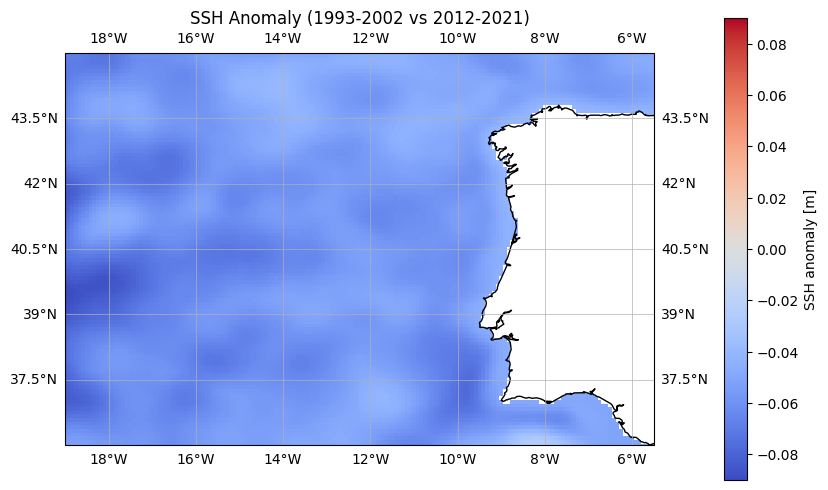

In [87]:
plot_anomaly_map(SSH.zos, title = 'SSH Anomaly (1993-2002 vs 2012-2021)', 
         vmin = -0.09, vmax = 0.09, cbar_label = 'SSH anomaly [m]')

In [88]:
# first 10 years 1993-2002 (including)
SSH_ref = SSH.zos.where(SSH.time.dt.isocalendar().year <= first_10, drop = True).mean(dim = 'time') 
# ref last 8 years 2012-2021 (including)
SSH_cur = SSH.zos.where(SSH.time.dt.isocalendar().year >= last_10, drop = True).mean(dim = 'time')  

In [91]:
SSH_anomaly = SSH_ref - SSH_cur

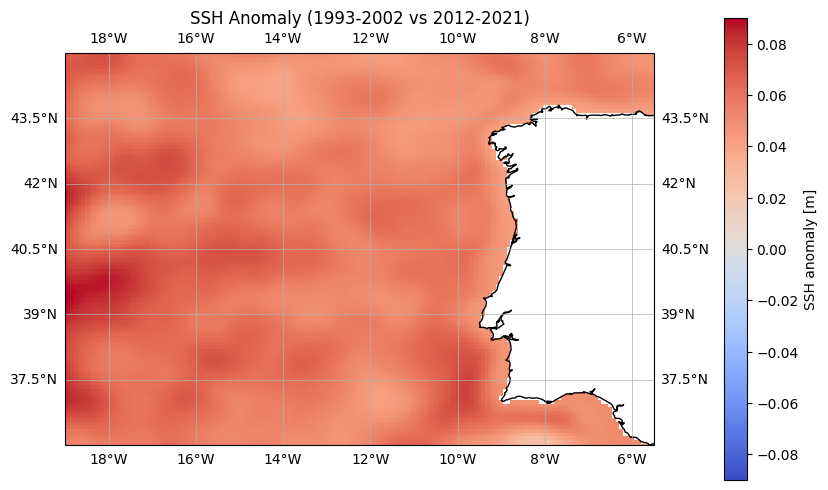

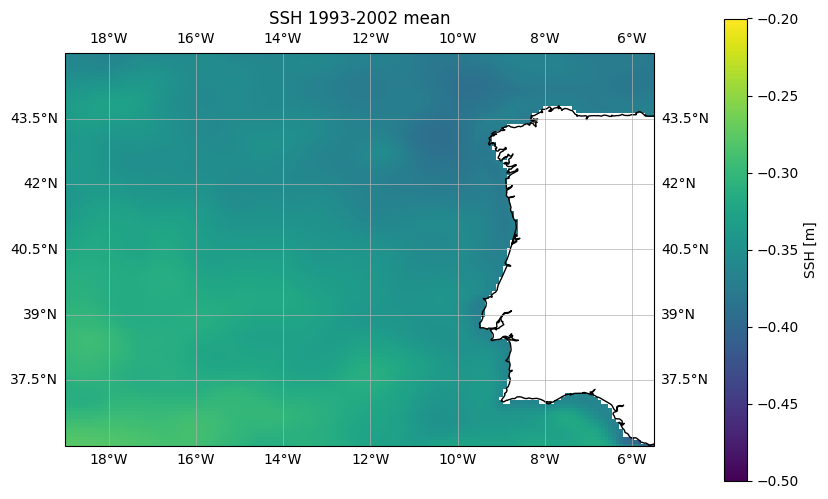

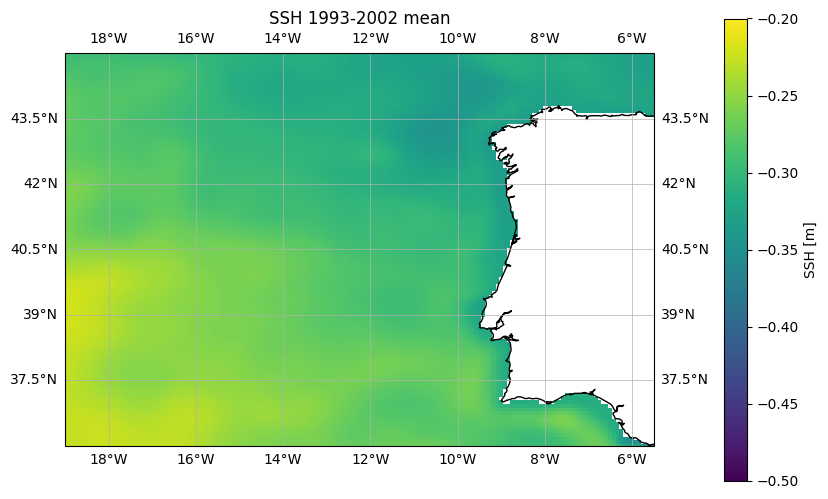

In [92]:
plot_map(SSH_anomaly * -1, title = 'SSH Anomaly (1993-2002 vs 2012-2021)', 
         vmin = -0.09, vmax = 0.09, cbar_label = 'SSH anomaly [m]')
plot_map(SSH_ref, title = 'SSH 1993-2002 mean', cmap = 'viridis', 
         vmin = -0.5, vmax = -0.2, cbar_label = 'SSH [m]')
plot_map(SSH_cur, title = 'SSH 1993-2002 mean', cmap = 'viridis',
         vmin = -0.5, vmax = -0.2, cbar_label = 'SSH [m]')

## Ekman

### Ek Mean

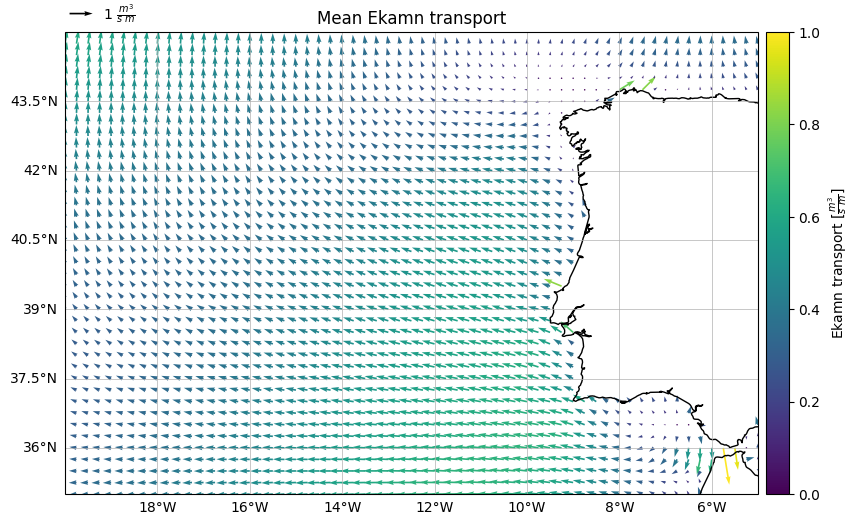

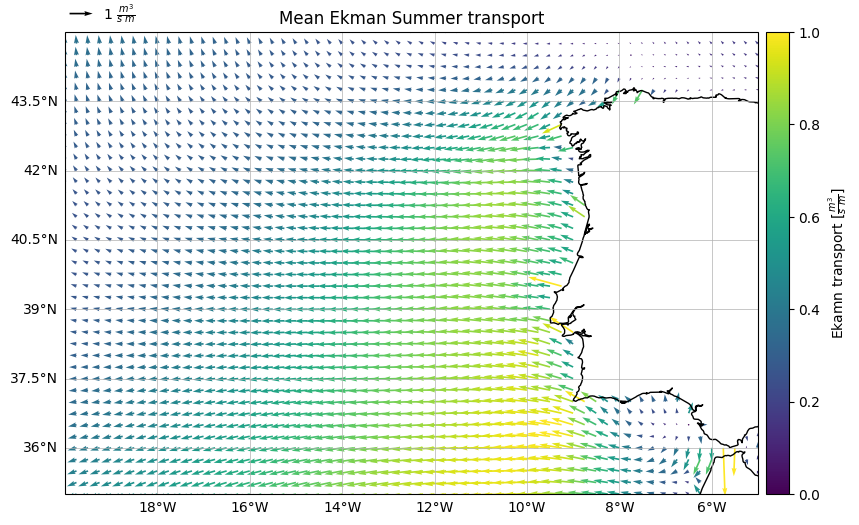

In [228]:
for DS, title in zip([Ek, Ek_summer], ['Mean Ekamn transport', 'Mean Ekman Summer transport']):
    # plot
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-20, -5, 45, 35])
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False  
    
    ax.set_title(title)
    col = np.hypot(DS.ek_trans_u.mean(dim = 'time'), DS.ek_trans_v.mean(dim = 'time'))
    im = ax.quiver(DS.lon, DS.lat, DS.ek_trans_u.mean(dim = 'time'), DS.ek_trans_v.mean(dim = 'time'), 
                             col, angles='xy', scale_units='xy', scale = 2, clim = [0,1]) 
    qk = ax.quiverkey(im, 0.04, 1.04, 1, r'1 $\frac{m^3}{s \ m}$', labelpos='E')
    plt.colorbar(im, label = r'Ekamn transport [$\frac{m^3}{s \ m}$]', pad = 0.01, fraction = 0.046);


### UI EK Trend

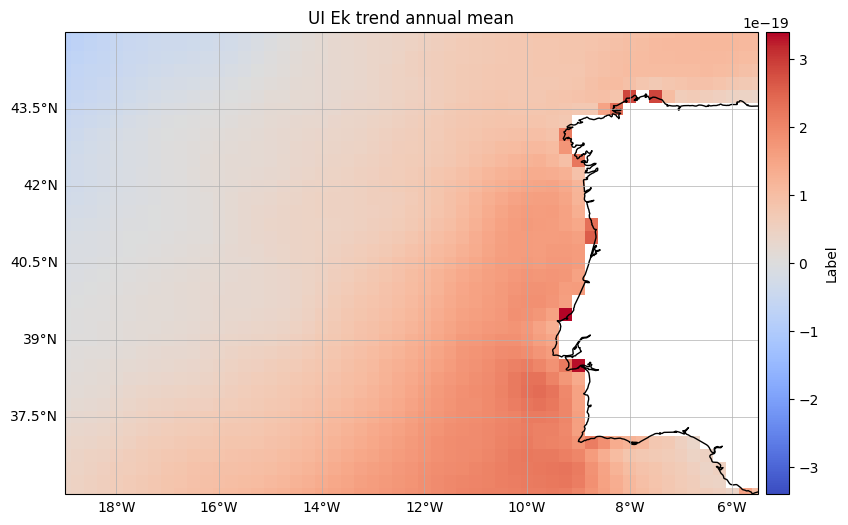

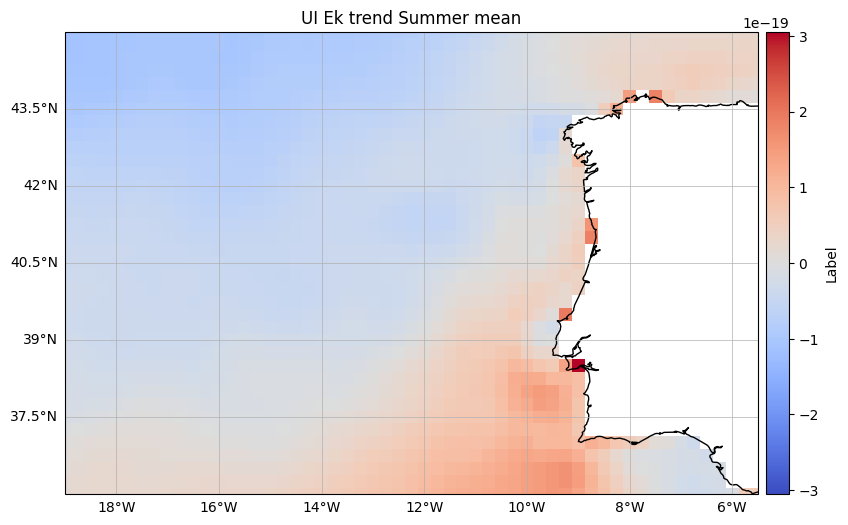

In [274]:
for DS, title in zip([Ek.UI, Ek_summer.UI], ['UI Ek trend annual mean', 'UI Ek trend Summer mean']):
    DS_annual = DS.resample(time = 'YE').mean() #* 10e18 # ato
    result = DS_annual.polyfit(dim = 'time', deg = 1)
    
    plot_map(result.polyfit_coefficients.sel(degree = 1), title = title) #, 
             #vmin = -2, vmax = 2, cbar_label = r'Slope of the trend [$10^{-18}$ m/year]')

In [292]:
def linear_func(x, m, c):
    return m * x + c
Decadal = Ek.resample(time = '10YE').mean() 
test = Decadal.UI.curvefit('time', linear_func)

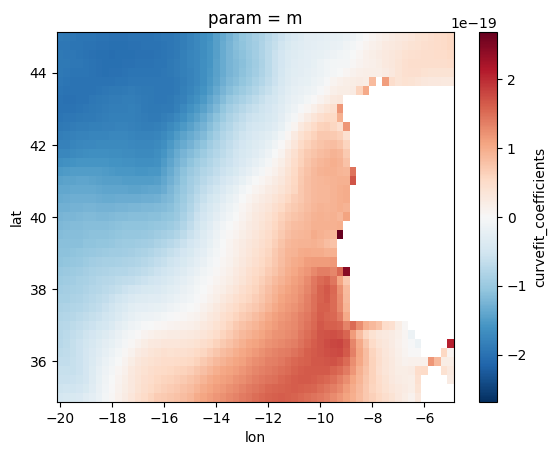

In [293]:
test.curvefit_coefficients.sel(param = 'm').plot()

In [277]:
## why is my trend so small?? what is going on?? ... I mean I hardly have a trend... maybe this is just 
## what happens with really small values... I don't like it

### UI Ek Anomaly

## SST

### SST Trend

### SST Anomaly